# CM50268 :: Final project (group work)

**Total Marks 25 (25% of overall unit grade).** 

*Submission deadline: 8pm, May 10, 2022. Please submit this file along with your individual report in Moodle*

## Submission & Marking

This group exercise is assessed, and the marks will contribute to your final grade. For this exercise there are a number of places where you are expected to enter your own code. Please see the BML Final Project Specification document for details. 

Every place you have to add code is described in the text and specifically indicated by the comment:

`#### **** YOUR CODE HERE **** ####`


**Please submit your completed workbook using Moodle before 8pm on May 10, 2022 along with your individual report**. The workbook you submit must be this `.ipynb` file, which is saved into the directory you're running Jupyter; alternatively you can download it from the menu above using `File -> Download As -> Notebook (.ipynb)`. Remember to save your work regularly (Save and Checkpoint in the File menu, the icon of a floppy disk, or Ctrl-S); the version you submit should have all code blocks showing the results (if any) of execution below them.

**You should take care to avoid any suggestion of plagiarism in your submission.** There is helpful information on how to avoid plagiarism on the University website: http://www.bath.ac.uk/library/help/infoguides/plagiarism.html

# Project setup

This coursework involves the evaluation of Bayesian modelling methods on a real multivariate regression task. Please check the pdf file for the details of the project.

- <font color=Red> Please try to use fixed random seeds to make your results reproducible </font>

- <font color=Red> Please do NOT change the name of the fixed variables, as Task 2 - Task 5 of this coding exercises are auto-marked </font>

The marks for Task 1 and Task 6 will be awarded based only on the content of the report.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.metrics import mean_absolute_error as mae 
from sklearn.metrics import mean_squared_error as mse
import hmc_Lab as hmc


In [2]:
#### **** YOUR CODE HERE **** ####  

#### **** You can add extra cells to illustrate your results **** ####  

# Load dataset
train = pd.read_csv('ee-train.csv')
test = pd.read_csv('ee-test.csv')

pre_X_train = train.iloc[:, 0:9]
pre_X_test = test.iloc[:, 0:9]

y_train = train.iloc[:, 9:10]
y_test = test.iloc[:, 9:10]

y_train = np.array(y_train).T.ravel()
y_test = np.array(y_test).T.ravel()

train.describe()

,const,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load
count,384.0,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000
mean,1.0,0.771042,665.774740,318.180990,173.796875,5.377604,3.536458,0.236849,2.783854,22.920703
std,0.0,0.106553,88.196712,42.248972,44.852410,1.747619,1.097695,0.133306,1.567506,10.066099
min,1.0,0.620000,514.500000,245.000000,110.250000,3.500000,2.000000,0.000000,0.000000,6.400000
25%,1.0,0.690000,588.000000,294.000000,140.875000,3.500000,3.000000,0.100000,1.000000,14.057500
50%,1.0,0.760000,661.500000,318.500000,147.000000,7.000000,4.000000,0.250000,3.000000,23.605000
75%,1.0,0.860000,735.000000,343.000000,220.500000,7.000000,5.000000,0.400000,4.000000,32.052500
max,1.0,0.980000,808.500000,416.500000,220.500000,7.000000,5.000000,0.400000,5.000000,43.100000


In [3]:
# Normalize the dependent variables (X)
from sklearn.preprocessing import normalize, RobustScaler, PowerTransformer, StandardScaler

transformer = StandardScaler()

# normalise X except constant bias
norm_X_train = transformer.fit_transform(pre_X_train.iloc[:, 1:])
norm_X_test = transformer.transform(pre_X_test.iloc[:, 1:])
norm_X_train = pd.DataFrame(norm_X_train, columns=pre_X_train.columns[1:])
norm_X_test = pd.DataFrame(norm_X_test, columns=pre_X_test.columns[1:])


In [4]:
X_train = np.concatenate((pre_X_train.iloc[:, 0:1], norm_X_train), axis = 1)
X_test = np.concatenate((pre_X_test.iloc[:, 0:1], norm_X_test), axis = 1)


# Task 6: Gaussian Processes

###  **(3 marks)**

There's no restriction on the GP implementation, you could either use the sklearn package or the Tensorflow style, the latter of which may receive extra bonus mark depending on the quality of implementation.  

You only need to estimate the weights from $x0$ to $x8$ in this task, then calculate RMSE and plot supporting figures for your report. 

<font color=Red>  It is highly recommended that you impelment this part in a seperated file if your implementation contains too many extra libraries, as it may fool the auto-marker and incorrectly mark the rest of your notebook. 
<font>   
    
    


In [5]:
from sklearn import gaussian_process as gp
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, ConstantKernel, RBF, RationalQuadratic, DotProduct
import seaborn as sns
import matplotlib.pyplot as plt

# reference: https://scikit-learn.org/stable/modules/gaussian_process.html#gpr-examples

k1 = RationalQuadratic()
k2 = RBF()
k3 = DotProduct() + RationalQuadratic()
k4 = DotProduct() + RBF()

kernel = k2

# Parameters of GaussianProcessRegressor
# - kernel: determine prior's covariance; hyperparameters optimised by maximising log-ML
# - n_restart_optimizer: start optimizer repeatedly to avoid getting stuck at local optima
# - alpha: noise in target
# - random_state: ensure reproducible results


gpr = gp.GaussianProcessRegressor(kernel=kernel,
                                  n_restarts_optimizer=10, 
                                  random_state=0,
                                  alpha= 1e-5
                                  )


In [6]:
# fit on training set
gpr.fit(X_train, y_train)


GaussianProcessRegressor(alpha=1e-05, kernel=RBF(length_scale=1),
                         n_restarts_optimizer=10, random_state=0)

In [7]:
gpr.kernel_


RBF(length_scale=1.09)

In [8]:
# get predictions
gpr_tr_y_pred, gpr_tr_std = gpr.predict(X_train, return_std=True)
gpr_y_pred, gpr_std = gpr.predict(X_test, return_std=True)


In [9]:
# optimal kernel
gpr.kernel_


RBF(length_scale=1.09)

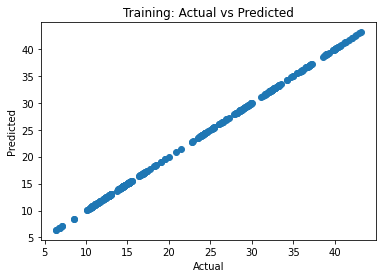

In [10]:
plt.figure()
plt.errorbar(y_train, gpr_tr_y_pred, yerr=gpr_tr_std, fmt='o')
# plt.title('Gaussian process regression, R2=%.2f' % r2_score(y_test, y_pred_te))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Training: Actual vs Predicted')
plt.show()

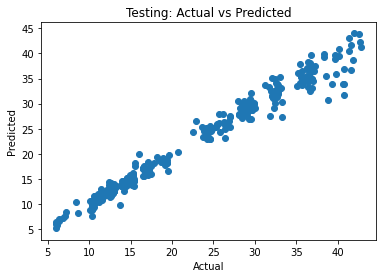

In [11]:
# sns.regplot(x=gp1_y_pred, y=y_test, scatter_kws={"color": "gray"}, line_kws={"color": "red"})

plt.figure()
plt.errorbar(y_test, gpr_y_pred, yerr=gpr_std, fmt='o')
# plt.title('Gaussian process regression, R2=%.2f' % r2_score(y_test, y_pred_te))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Testing: Actual vs Predicted')
plt.show()



Text(0.5, 1.0, '(Training) Distribution of Residuals')

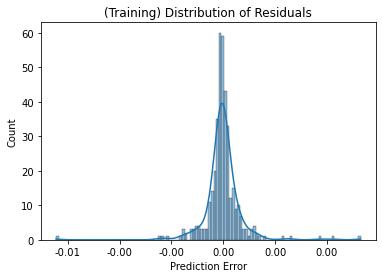

In [12]:
from matplotlib.ticker import StrMethodFormatter
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places

sns.histplot(gpr_tr_y_pred - y_train, kde=True)
plt.xlabel('Prediction Error')
plt.title('(Training) Distribution of Residuals')


Text(0.5, 1.0, '(Testing) Distribution of Residuals')

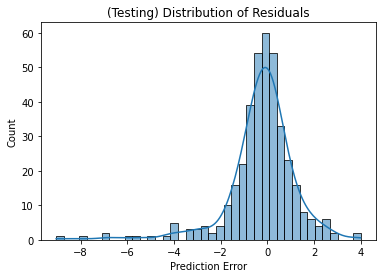

In [13]:
sns.histplot(gpr_y_pred - y_test, kde=True)
plt.xlabel('Prediction Error')
plt.title('(Testing) Distribution of Residuals')

In [14]:
# GP results

gpr_train_rmse = mse(y_train, gpr_tr_y_pred, squared=False)
gpr_test_rmse = mse(y_test, gpr_y_pred, squared=False)
gpr_train_mse = mse(y_train, gpr_tr_y_pred)
gpr_test_mse = mse(y_test, gpr_y_pred)
gpr_train_mae = mae(y_train, gpr_tr_y_pred)
gpr_test_mae = mae(y_test, gpr_y_pred)

print('Training RMSE: ', gpr_train_rmse)
print('Testing RMSE: ', gpr_test_rmse)
print()
print('Training MSE: ', gpr_train_mse)
print('Testing MSE: ', gpr_test_mse)
print()
print('Training MAE: ', gpr_train_mae)
print('Testing MAE: ', gpr_test_mae)


Training RMSE:  0.0007402538495106242
Testing RMSE:  1.4966644408669767

Training MSE:  5.47975761715298e-07
Testing MSE:  2.24000444855566

Training MAE:  0.0003890188575335028
Testing MAE:  0.9494229863953851
